# Clasificación usando Machine Learning

Nuestra primera tarea será verificar que tenemos las librerías necesarias. 

Recuerdo: Una celda se ejecuta con "Shift" + "Enter" (o con el ícono "Run").

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import altair as alt
print("Pandas version", pd.__version__)
print("Altair version", alt.__version__)
from sklearn import __version__ as sklearn_version
print("Sklearn version", sklearn_version)

from time import time

np.random.seed(42)
alt.themes.enable("opaque")

%matplotlib inline

Pandas version 1.0.2
Altair version 4.0.1
Sklearn version 0.22.2.post1


## Caso Práctico

Se utilizará un conjunto de datos relacionados con campañas de marketing directo (llamadas telefónicas) de una institución bancaria portuguesa. El objetivo de la clasificación es predecir si el cliente suscribirá un depósito a plazo.

Los datos se pueden encontrar en el siguiente [link](https://archive.ics.uci.edu/ml/datasets/Bank%2BMarketing), pero ya se encuentran descargados localmente en la carpeta `data`, por lo que ya se encuentran disponibles en este notebook.

Para realizar tal labor se procederá de la siguiente manera:

1. Lectura de datos
2. Análisis descriptivo
3. Visualizaciones
4. Pre-procesamiento
5. Modelo de Clasificación
6. Interpretación

## 1. Lectura de Datos

Para leer el archivo existen múltiples opciones. Pandas nos entrega una manera sencilla de leer los datos.

In [2]:
# Generar la ruta
filepath = os.path.join("data", "bank-full.csv")
# Leer los datos en el filetpath  y con el separador ;
bank = pd.read_csv(filepath, sep=";")

In [3]:
# Mostrar las primeras filas
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Mostrar las columnas
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [5]:
# Ver el tamaño del dataset
bank.shape

(45211, 17)

El archivo `bank-names.txt` nos entrega toda la información detallada al conjunto de datos a utilizar. En particular nos interesa el punto 7, donde se definen las columnas.

In [6]:
%cat data/bank-names.txt

**Resumen**:

* Los datos se relacionan con marketing directo de una institucion bancaria. Las campañas de marketing 

* El dataset completo (bank-full.csv) tiene 45,211 ejemplos (elementos de aprendizaje). Cada ejemplo tiene 16 atributos (x) y un valor a predecir (y): yes/no.

**ATRIBUTOS**
* Bank client data:
   1. age (numeric)
   2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4. education (categorical: "unknown","secondary","primary","tertiary")
   5. default: has credit in default? (binary: "yes","no")
   6. balance: average yearly balance, in euros (numeric) 
   7. housing: has housing loan? (binary: "yes","no")
   8. loan: has personal loan? (binary: "yes","no")


  * Related with the last contact of the current campaign:
   9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
   10. day: last contact day of the month (numeric)
   11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   12. duration: last contact duration, in seconds (numeric)


  * Otros:
   13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
   15. previous: number of contacts performed before this campaign and for this client (numeric)
   16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

* Variable "y" a predecir: ¿El cliente suscribió un depósito a plazo?

## 2. Análisis Descriptivo

Lo primero es saber las columnas utilizadas, si es que poseen elementos nulos y el tipo de columna. Adicionalmente se puede obtener la cantidad de memoria RAM utilizada por este dataframe.

In [7]:
bank.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Luego sigue un análisis descriptivo de los datos, como ver medidas de dispersión (mínimo, máximo, promedio, etc.) para datos numéricos y medidas de frecuencia para datos categóricos.

In [8]:
bank.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,45211,NaN,NaN,NaN,40.9362,10.6188,18,33,39,48,95
job,45211,12,blue-collar,9732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,45211,3,married,27214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,45211,4,secondary,23202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,45211,2,no,44396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,45211,NaN,NaN,NaN,1362.27,3044.77,-8019,72,448,1428,102127
housing,45211,2,yes,25130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,45211,2,no,37967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,45211,3,cellular,29285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,45211,NaN,NaN,NaN,15.8064,8.32248,1,8,16,21,31


**Tip**: Usar fillna("") permite enmascarar los nans y solo observar los valores existentes. 

In [9]:
bank.describe(include="all").fillna("").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,45211,,,,40.9362,10.6188,18,33,39,48,95
job,45211,12,blue-collar,9732,,,,,,,
marital,45211,3,married,27214,,,,,,,
education,45211,4,secondary,23202,,,,,,,
default,45211,2,no,44396,,,,,,,
balance,45211,,,,1362.27,3044.77,-8019,72,448,1428,102127
housing,45211,2,yes,25130,,,,,,,
loan,45211,2,no,37967,,,,,,,
contact,45211,3,cellular,29285,,,,,,,
day,45211,,,,15.8064,8.32248,1,8,16,21,31


Algunos análisis sobre nuestra variable de interés `y`

In [10]:
bank["y"].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [11]:
bank["y"].value_counts().pipe(lambda s: s["no"] / s["yes"])

7.548118737001324

Por cada 7.5 "no" (approximadamente) hay un "yes". 

In [12]:
bank["y"].value_counts().pipe(lambda s: s["yes"] / s.sum() * 100)

11.698480458295547

Sólo hay alrededor de un 11% de datos positivos, en la literatura se suele decir que es un conjunto de datos __desbalanceado__.

## 3. Visualización

Veamos como se distribuyen los datos numéricos respecto a la variable de interés

In [13]:
# Selección de columnas de tipo numéricas
numeric_columns = bank.select_dtypes("number").columns.tolist()

In [14]:
numeric_columns

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [15]:
# Es posible concatenar los strings con un caracter (o string) común:
" / ".join(numeric_columns)

'age / balance / day / duration / campaign / pdays / previous'

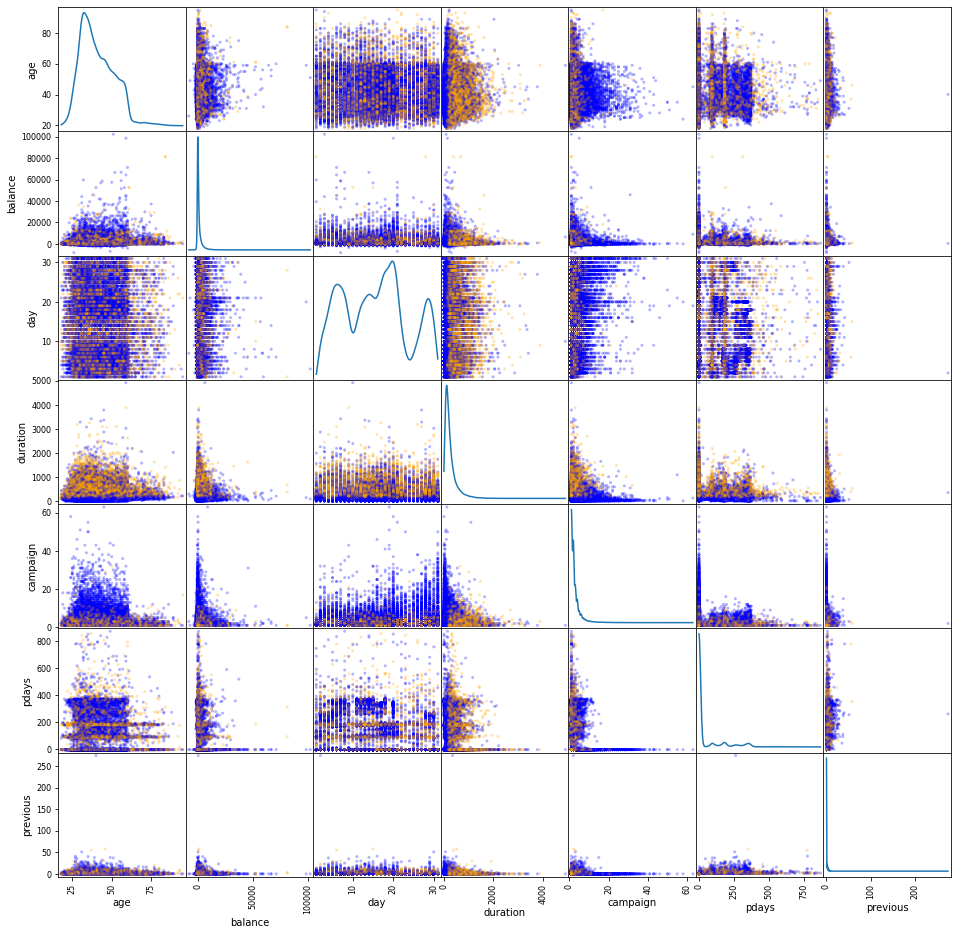

In [129]:
if X.shape[0]<6000:
    # Gráfico con Altair
    alt.Chart(bank).mark_circle(opacity=0.3).encode(
        x=alt.X(alt.repeat("column"), type='quantitative'),
        y=alt.Y(alt.repeat("row"), type='quantitative'),
        color='y:N'
    ).properties(
        width=200,
        height=200
    ).repeat(
        row=numeric_columns,
        column=numeric_columns
    )
else:
    # Gráfico con pandas y matplotlib
    colors=['blue','orange']
    scatter_matrix(X[numeric_columns], figsize=(16, 16), alpha=0.3, diagonal='kde', c=y.apply(lambda x: colors[x]));

Ahora con los datos categóricos

In [17]:
# Selección de columnas de tipo objeto (categóricas)
object_columns = bank.drop(columns="y").select_dtypes("object").columns.tolist()

In [18]:
object_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [19]:
# Es posible concatenar los strings con un caracter (o string) común:
" / ".join(object_columns)

'job / marital / education / default / housing / loan / contact / month / poutcome'

In [138]:
if X.shape[0]<6000:
    # Graficar con Altair
    alt.Chart(bank).mark_bar().encode(
        x=alt.X(alt.repeat("row"), type='nominal'),
        y='count()', #y='count()',
        color='y:N'
    ).properties(
        width=400,
        height=300
    ).repeat(
        row=object_columns,
    )
else:
    # Gráfico con pandas y matplotlib
    pass
    # X["job"].value_counts().plot.bar(stacked=True);
    #colors=['blue','orange']
    #scatter_matrix(X[object_columns], figsize=(16, 16), alpha=0.3, diagonal='kde', c=y.apply(lambda x: colors[x]));    

## 4. Pre-procesamiento

En esta sección se realizarán una serie de manipulación a los datos, con tal de implementar los modelos de clasificación en la siguien etapa. 

Los procesos típicos consideran definir la matriz de diseño `X`, el vector de respuesta `y`, dividir en conjunto de entrenamiento-test, realizar modificaciones a algunas columnas e incluso definir un _pipeline_ de transformaciones a realizar al conjunto de datos.

Se define la matriz de diseño y el vector de respuesta de forma usual, salvo que la variable `y` tendrá datos 0 y 1, en lugar de _no_ y _yes_, esto por practicidad a la hora de implementar las métricas de evaluación del desempeño.

In [21]:
X = bank.drop(columns="y")
y_label_dict = {"yes": 1, "no": 0}
y = bank["y"].map(y_label_dict)

In [22]:
# Veamos la matriz X que seleccionamos
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


In [23]:
# Mirar las primeros n filas
y.head(n=10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: y, dtype: int64

Se realiza la división de los sets de entrenamiento-test a razón de 80-20 y de manera estratificada dada la cantidad de datos que disponemos.

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Una división estratificada permite que los datasets que se generan posean una distribución similar. De otra manera, podría suceder sucedería que los conjunto de entrenamiento y test tendrían distribuciones distintas al conjunto completo, con un sezgo no real que se traspasaría al modelo.

Revisemos que la división estratificada se hizo correctamente:

In [26]:
print(f"La razón entre valores 'no' y 'yes'  en el conjunto de entrenamiento es {y_train.value_counts().pipe(lambda s: s[0] / s[1]):.1f}")
print(f"Porcentaje de valores 'yes' en el conjunto de entrenamiento es {y_train.value_counts().pipe(lambda s: 100*s[1] / s.sum()):.1f}%")
print(f"La razón entre valores 'no' y 'yes' en el conjunto de test es {y_test.value_counts().pipe(lambda s: s[0] / s[1]):.1f}")
print(f"Porcentaje de valores 'yes' en el conjunto de entrenamiento es {y_test.value_counts().pipe(lambda s: 100*s[1] / s.sum()):.1f}%")

La razón entre valores 'no' y 'yes'  en el conjunto de entrenamiento es 7.5
Porcentaje de valores 'yes' en el conjunto de entrenamiento es 11.7%
La razón entre valores 'no' y 'yes' en el conjunto de test es 7.5
Porcentaje de valores 'yes' en el conjunto de entrenamiento es 11.7%


En cuento al *workflow*, una buena práctica es realizar la definición de pasos a seguir en un clasificador utilizando `Pipeline` ([documentación](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)). En nuestro caso primero se definen una serie de transformaciones y luego el modelo clasificador a utilizar.

Entonces, primero se definen las transformaciones que se realizarán.

* Columnas numéricas se escalan.
* Columnas categóricas se codifican utilizando la técnica _One Hot Encoding_.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [28]:
print("Columnas numéricas:", ", ".join(numeric_columns))
print("Columnas categóricas:", ", ".join(object_columns))

Columnas numéricas: age, balance, day, duration, campaign, pdays, previous
Columnas categóricas: job, marital, education, default, housing, loan, contact, month, poutcome


In [29]:
numeric_transformer = Pipeline(
    steps=[('scaler', StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[('onehot', OneHotEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, object_columns)])

## 5. Clasificación

### 5.1 Una primera clasificación

Se crea un clasificador que considera la transformación anterior y además una regresión logística. En general, se suele considerar una buena práctica aplicar un modelo conocido base como regresión logísticas antes de utilizar modelos más complejos, puesto que permite tener una idea de la complejidad del problema.

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=200))
    ]
)

Entrenamos los datos

In [73]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                      

Finalmente obtenemos el _score_

In [74]:
print(f"El score del modelo utilizando Regresión Logística es {clf.score(X_test, y_test):.3f}")

El score del modelo utilizando Regresión Logística es 0.901


El entrenamiento del modelo fue extremadamente eficiente. A pesar de considerar +45,000 ejemplos, tomó menos de un segundo. Más precisamente:

In [75]:
import time
toc = time.time()
clf.fit(X_train, y_train)
tic = time.time()
print("Entrenamiento tomó {} segundos".format(tic-toc))

Entrenamiento tomó 0.4928710460662842 segundos


Una manera gráfica de ver los resultados es utilizando la **Matriz de Confusión**, que puede aplicarse tanto al conjunto de entrenamiento como al conjunto de predicción: 

In [76]:
from sklearn.metrics import plot_confusion_matrix
print("Conjunto de entrenamiento:", X_train.shape)
print("Conjunto de test:", X_test.shape)

Conjunto de entrenamiento: (36168, 16)
Conjunto de test: (9043, 16)


In [62]:
plot_confusion_matrix?

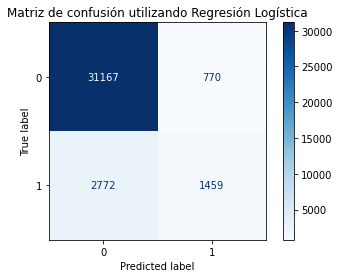

In [77]:
# Matriz de confusión para valores totales - dataset de predicción
cm = plot_confusion_matrix(
    clf,
    X_train,
    y_train,
    cmap=plt.cm.Blues,
    values_format=".0f",
    #normalize = "all", # all, pred, true
)
cm.ax_.set_title("Matriz de confusión utilizando Regresión Logística")
plt.show()

![](images/prediction_error.jpeg)

La interpretación de una matriz de confusión es la siguiente:
* True label 0 y Predicted label 0: True negatives - Casos negativos predichos exitosamente.
* True label 1 y Predicted label 0: False negatives - Casos predichos como negativos que eran en realidad positivos.
* True label 0 y Predicted label 1: False positives - Casos predichos como positivos que eran en realidad negativos.
* True label 1 y Predicted label 1: True positives - Casos positivos predichos exitosamente.

¿Se comporta de la misma manera en el conjunto de test?

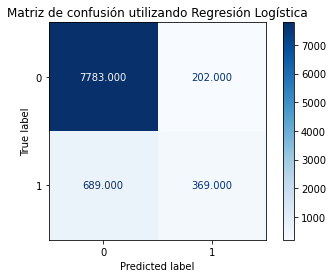

In [86]:
# Matriz de confusión para valores totales - dataset de predicción
cm = plot_confusion_matrix(
    clf,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    values_format=".3f",
    #normalize="true", # all, pred, true
)
cm.ax_.set_title("Matriz de confusión utilizando Regresión Logística")
plt.show()

* ¿Cuantos casos de Falsos Positivos? 
* ¿Cuantos casos de Falsos Negativos?

**INTERPRETACIÓN DE LA LINEA BASE**

* Considerando la predicción:
  * Cuando se predice "0", el 91.9% de las predicciones son correctas ("0", no se vende).
  * Cuando se predice "1", el 64.6% de las predicciones son correctas ("1", se vende).

* Considerando el estado real:
  * Del estado real "0", la predicción captura correctamente el 97.5% de los casos.
  * Del estado real "1", la predicción captura correctamente el 34.9% de los casos.

In [84]:
from sklearn.metrics import classification_report
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.919     0.975     0.946      7985
           1      0.646     0.349     0.453      1058

    accuracy                          0.901      9043
   macro avg      0.782     0.662     0.699      9043
weighted avg      0.887     0.901     0.888      9043



Comparar múltiples modelos utilizando todas estas cifras es complejo. 
Por eso se suele utilizar un único valor para compararlos. 
El **score** es una medida única del modelo, que tipicamente es el recall (wighted average recall):

*The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.*

In [43]:
print("Train score: ", clf.score(X_train, y_train))
print("Test score: ", clf.score(X_test, y_test))

Train score:  0.9020681265206812
Test score:  0.9014707508570164


### 5.2 Utilizando otros modelos

Probaremos distintos clasificadores para luego escoger el que mejor se ajusta a estos datos.

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [45]:
classifiers_dict = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "KNN": KNeighborsClassifier(3),
    "SVC": SVC(kernel="linear", C=0.025),
    "Decession Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),  
}

In [46]:
for name, model in classifiers_dict.items():
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ]
    )
    clf.fit(X_train, y_train)
    print(f"El score del modelo utilizando {name} es {clf.score(X_test, y_test):.3f}")

El score del modelo utilizando Logistic Regression es 0.901
El score del modelo utilizando KNN es 0.895
El score del modelo utilizando SVC es 0.893
El score del modelo utilizando Decession Tree es 0.899
El score del modelo utilizando Random Forest es 0.883


**INTERPRETACIÓN**:

¿Qué modelo utilizaría?

...

Considere que no hemos ajustado los meta-parámetros de cada modelo. ¡La precisión de los modelos podría mejorar!

### 5.3 Encontrando  los mejores parámetros de un modelo

Los hiperparámetros son parámetros que no se aprenden directamente dentro de los estimadores. En scikit-learn se pasan como argumentos al constructor de las clases de estimador. Es posible y recomendable buscar en el espacio de hiperparámetros la mejor puntuación de validación cruzada.

Por ejemplo, utilizando un modelo _Support Vector Classifier_ realizaremos una búsqueda de los hiperparámetros `C` y `kernel`.

In [47]:
from sklearn.model_selection import GridSearchCV

In [88]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC())
    ]
)

param_grid = {
    # Full - several combinations
    #'classifier__C' : [0.01, 0.01, 1, 10, 100],
    #'classifier__kernel': ('rbf', 'linear')
    # Reducido
    'classifier__C' : [0.25, 1, 25],   
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring="recall",
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

In [89]:
# PACIENCIA: Ejecución toma cerca de 5-10 minutos.
import time
print("Realizando grid search...")
print("\tpipeline:", [name for name, _ in pipeline.steps])
print("\tparameters:")
print(f"\t{param_grid}")
toc = time.time()
grid_search.fit(X_train, y_train)
tic = time.time()
print(f"Realizado en {tic-toc:0.1f} segundos\n")
print(f"Best score: {grid_search.best_score_:0.3f}")
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Realizando grid search...
	pipeline: ['preprocessor', 'classifier']
	parameters:
	{'classifier__C': [0.25, 1, 25]}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.6min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.5min finished


Realizado en 339.2 segundos

Best score: 0.453
Best parameters set:
	classifier__C: 25


Puedes ver el resumen de la ejecución anterior

In [90]:
grid_search.cv_results_

{'mean_fit_time': array([ 52.09927559,  55.05609961, 118.86429272]),
 'std_fit_time': array([ 0.24440906,  0.3770748 , 24.39825603]),
 'mean_score_time': array([8.06990299, 7.90971355, 4.08333783]),
 'std_score_time': array([0.06537171, 0.07657083, 0.45276249]),
 'param_classifier__C': masked_array(data=[0.25, 1, 25],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__C': 0.25},
  {'classifier__C': 1},
  {'classifier__C': 25}],
 'split0_test_score': array([0.27541371, 0.3321513 , 0.46926714]),
 'split1_test_score': array([0.26713948, 0.31205674, 0.42316785]),
 'split2_test_score': array([0.28571429, 0.34356553, 0.4498229 ]),
 'split3_test_score': array([0.30023641, 0.35579196, 0.46572104]),
 'split4_test_score': array([0.28841608, 0.34751773, 0.45744681]),
 'mean_test_score': array([0.28338399, 0.33821665, 0.45308515]),
 'std_test_score': array([0.01133283, 0.01513368, 0.01640874]),
 'rank_test_score': array([3, 2, 1]

Como también el mejor estimador obtenido

In [91]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                      

Si recuerdas, la métrica utilizada fue el _recall_, `scikit-learn` permite incluso calcular el `recall` para ambas etiquetas de clasificación.

In [93]:
from sklearn.metrics import recall_score
recall_score(grid_search.best_estimator_.predict(X_train), y_train, average=None)

array([0.96456477, 0.90188014])

In [95]:
y_test_pred = grid_search.best_estimator_.predict(X_test)
print(f"El score del modelo es {clf.score(X_test, y_test_pred):.3f}")

El score del modelo es 0.938


Es decir, por buscar parámetros (en un espacio muy reducido) hemos aumentado el score del modelo desde 0.893 a 0.938, ¡superando a la regresión logística!

Podemos incluso volver a graficar la matriz de confusión.

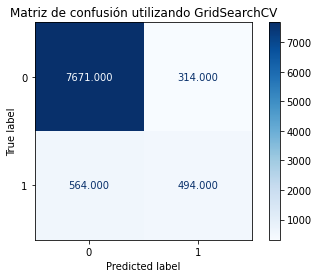

In [104]:
cm = plot_confusion_matrix(
    grid_search,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    values_format=".3f",
    #normalize="all", # all, pred, true

)

cm.ax_.set_title("Matriz de confusión utilizando GridSearchCV")
plt.show()

In [100]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.932     0.961     0.946      7985
           1      0.611     0.467     0.529      1058

    accuracy                          0.903      9043
   macro avg      0.771     0.714     0.738      9043
weighted avg      0.894     0.903     0.897      9043



In [116]:
# Sandbox para calculos

## 6. Interpretación de Negocio

¿Cómo podemos interpretar los números anteriores?

* Considerando la predicción:
  * Se predicen 808 respuestas positivas ("1") y 7985 respuestas negativas ("0"): 8.9% de respuestas positivas. 
  * Cuando se predice "0", el 93.2% de las predicciones son correctas ("0", no se vende).
  * Cuando se predice "1", el 61.1% de las predicciones son correctas ("1", se vende).

* Considerando el estado real:
  * Existen 1058 respuestas positivas ("1") y 7985 respuestas negativas ("0"): 11.7% de respuestas positivas. 
  * Del estado real "0", la predicción captura correctamente el 96.1% de los casos.
  * Del estado real "1", la predicción captura correctamente el 46.7% de los casos.
  
Pensemos que se planteaba abordar una nueva campaña de marketing para 1000 personas. Históricamente, de éstas 1000 personas sólo un 11.7% terminaba adquiriendo el depósito a plazo, es decir, 117 personas.

El modelo predictivo indica que sólo es necesario entrevistar a 89 personas, de las cuales 89 x 0.61 = 54 probablemente adquirirán el servicio. 

Supongamos que la campaña de marketing tiene un costo X, y que el banco tiene una ganancia de Y.

* Modelo tradicional de Marketing presenta una ganancia de 117 Y - 1000 X.
* Modelo de Machine Learning presenta una ganacia de  54 Y - 89 X.

Es decir, es posible acceder a cerca de la mitad de la población objetivo concentrando el esfuerzo en menos del 10% del público total.

En este caso, la segmentación ha sido "absoluta": 0 y 1. Si en lugar de eso se predice una propención a la compra (rango 0-100), es posible trabajar en una segmentación de mercado más eficiente.

## Trabajos futuros

Algunas ideas interesantes para mejorar el modelo de clasificación pueden ser:

- Obtener más datos, con tal que el algoritmo pueda _aprender_ de mejor manera.
- Realizar _hyper-parameters tuning_ con más modelos, más parámetros e incluso con una grilla más fina (lo cual requiera mucho más tiempo poder de cómputo).